

---



In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

![][image1]

[image1]: <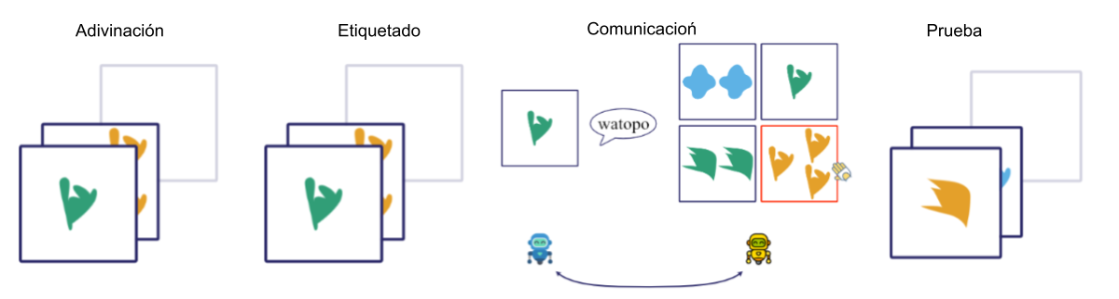>


Proceso de juego referencial con LLMs: Adivinación, donde el oyente intenta identificar un estímulo a partir de una palabra dada. Etiquetado, donde los agentes generan palabras para los estímulos y se evalúa su coherencia. Comunicación, donde un hablante describe un estímulo y un oyente debe reconocerlo entre varias opciones. Prueba, donde se mide la capacidad de generalización a nuevos estímulos analizando la estructura de la comunicación emergente.

# Adivinación

In [ ]:
# Usamos un modelo ligero: EleutherAI/gpt-neo-125M
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Definición de un vocabulario de ejemplo (esto simula la parte de "etiquetado" previo)
vocabulary = [
    {"Estímulo": {"shape": 1, "colour": "blue",   "amount": 2}, "palabra": "sunupepi"},
    {"Estímulo": {"shape": 2, "colour": "green",  "amount": 1}, "palabra": "ginisu"},
    {"Estímulo": {"shape": 3, "colour": "orange", "amount": 3}, "palabra": "wipipitite"},
    {"Estímulo": {"shape": 4, "colour": "red",    "amount": 2}, "palabra": "kilatu"},
    {"Estímulo": {"shape": 5, "colour": "yellow", "amount": 1}, "palabra": "lumofe"},
    {"Estímulo": {"shape": 6, "colour": "purple", "amount": 4}, "palabra": "zivuro"},
    {"Estímulo": {"shape": 7, "colour": "pink",   "amount": 3}, "palabra": "noripa"},
    {"Estímulo": {"shape": 8, "colour": "brown",  "amount": 2}, "palabra": "tebokri"},
    {"Estímulo": {"shape": 9, "colour": "cyan",   "amount": 1}, "palabra": "fexanu"},
    {"Estímulo": {"shape": 10, "colour": "gray",  "amount": 5}, "palabra": "dolimexi"}
]

# Función que construye el prompt basado en el vocabulario y el estímulo a adivinar
def build_prompt(vocab, test_stimulus):
    prompt = """ Eres un aprendiz de lenguajes articiales que puede decir una palabra a partir de un estímulo.
    Dado el siguiente vocabulario:\n"""
    for entry in vocab:
        stim = entry["Estímulo"]
        prompt += f"Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} -> palabra: {entry['palabra']}\n"
    prompt += f"\¿cuál es la palabra para el estímulo: shape={test_stimulus['shape']}, colour={test_stimulus['colour']}, amount={test_stimulus['amount']}?\nRespuesta: "
    print(prompt)
    return prompt

# Función que utiliza el modelo para "adivinar" la señal del estímulo
def guess_signal(test_stimulus):
    prompt = build_prompt(vocabulary, test_stimulus)
    inputs = tokenizer(prompt, return_tensors="pt")
    # Generamos la respuesta sin muestreo (modo determinista)
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extraemos la respuesta que sigue a "Respuesta:"
    answer = generated.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    return answer

# Ejemplo: estímulo de prueba
test_stimulus ={"shape": 1, "colour": "blue",  "amount": 2}
predicted_signal = guess_signal(test_stimulus)
print("---> Señal predicha:", predicted_signal)

test_stimulus ={"shape": 2, "colour": "green", "amount": 1}
predicted_signal = guess_signal(test_stimulus)
print("---> Señal predicha:", predicted_signal)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

 Eres un aprendiz de lenguajes articiales que puede decir una palabra a partir de un estímulo.
    Dado el siguiente vocabulario:
Estímulo: shape=1, colour=blue, amount=2 -> palabra: sunupepi
Estímulo: shape=2, colour=green, amount=1 -> palabra: ginisu
Estímulo: shape=3, colour=orange, amount=3 -> palabra: wipipitite
Estímulo: shape=4, colour=red, amount=2 -> palabra: kilatu
Estímulo: shape=5, colour=yellow, amount=1 -> palabra: lumofe
Estímulo: shape=6, colour=purple, amount=4 -> palabra: zivuro
Estímulo: shape=7, colour=pink, amount=3 -> palabra: noripa
Estímulo: shape=8, colour=brown, amount=2 -> palabra: tebokri
Estímulo: shape=9, colour=cyan, amount=1 -> palabra: fexanu
Estímulo: shape=10, colour=gray, amount=5 -> palabra: dolimexi
\¿cuál es la palabra para el estímulo: shape=1, colour=blue, amount=2?
Respuesta: 
---> Señal predicha: sunupepi
 Eres un aprendiz de lenguajes articiales que puede decir una palabra a partir de un estímulo.
    Dado el siguiente vocabulario:
Estímulo: 

# Etiquetado


In [ ]:
# 🔹 Definir vocabulario inicial
vocabulary = [
    {"Estímulo": {"shape": 1, "colour": "blue",   "amount": 2}, "palabra": "sunupepi"},
    {"Estímulo": {"shape": 2, "colour": "green",  "amount": 1}, "palabra": "ginisu"},
    {"Estímulo": {"shape": 3, "colour": "orange", "amount": 3}, "palabra": "wipipitite"},
    {"Estímulo": {"shape": 4, "colour": "red",    "amount": 2}, "palabra": "kilatu"},
    {"Estímulo": {"shape": 5, "colour": "yellow", "amount": 1}, "palabra": "lumofe"},
    {"Estímulo": {"shape": 6, "colour": "purple", "amount": 4}, "palabra": "zivuro"},
    {"Estímulo": {"shape": 7, "colour": "pink",   "amount": 3}, "palabra": "noripa"},
    {"Estímulo": {"shape": 8, "colour": "brown",  "amount": 2}, "palabra": "tebokri"},
    {"Estímulo": {"shape": 9, "colour": "cyan",   "amount": 1}, "palabra": "fexanu"},
    {"Estímulo": {"shape": 10, "colour": "gray",  "amount": 5}, "palabra": "dolimexi"}
]

# 🔹 Función para encontrar o generar etiquetas lingüísticas
def etiquetar_estimulo(estimulo, vocabulario):
    for entrada in vocabulario:
        if entrada["Estímulo"] == estimulo:
            return entrada["palabra"]
    # Si no se encuentra, generar una nueva palabra (ejemplo simple)
    nueva_palabra = "gen" + str(len(vocabulario) + 1)
    vocabulario.append({"Estímulo": estimulo, "palabra": nueva_palabra})
    return nueva_palabra

# 🔹 Prueba de etiquetado
estimulo_prueba = {"shape": 3, "colour": "orange", "amount": 3}  # Debería devolver "wipipitite"
etiqueta = etiquetar_estimulo(estimulo_prueba, vocabulary)
print("Etiqueta asignada:", etiqueta)

# 🔹 Prueba con un estímulo nuevo
estimulo_nuevo = {"shape": 11, "colour": "gold", "amount": 2}  # Debería generar una nueva palabra
nueva_etiqueta = etiquetar_estimulo(estimulo_nuevo, vocabulary)
print("Etiqueta generada:", nueva_etiqueta)

Etiqueta asignada: wipipitite
Etiqueta generada: gen11


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# 🔹 Cargar BabyLLaMA
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# 🔹 Definir vocabulario inicial
vocabulary = [
    {"Estímulo": {"shape": 1, "colour": "blue",   "amount": 2}, "palabra": "sunupepi"},
    {"Estímulo": {"shape": 2, "colour": "green",  "amount": 1}, "palabra": "ginisu"},
    {"Estímulo": {"shape": 3, "colour": "orange", "amount": 3}, "palabra": "wipipitite"},
    {"Estímulo": {"shape": 3, "colour": "red",    "amount": 2}, "palabra": "kilatu"},
    {"Estímulo": {"shape": 3, "colour": "yellow", "amount": 1}, "palabra": "lumofe"},
    {"Estímulo": {"shape": 1, "colour": "purple", "amount": 4}, "palabra": "zivuro"},
    {"Estímulo": {"shape": 2, "colour": "pink",   "amount": 3}, "palabra": "noripa"},
    {"Estímulo": {"shape": 1, "colour": "brown",  "amount": 2}, "palabra": "tebokri"},
    {"Estímulo": {"shape": 1, "colour": "cyan",   "amount": 1}, "palabra": "fexanu"},
    {"Estímulo": {"shape": 2, "colour": "gray",  "amount": 5}, "palabra": "dolimexi"}
]

# 🔹 Función para generar palabras con BabyLLaMA
def generar_palabra_llm(estimulo):
    prompt = f"""
    # Tarea de aprendizaje de lenguaje artificial

    Eres un asistente especializado en aprender patrones lingüísticos. Tu tarea es aprender un lenguaje artificial donde cada palabra corresponde a una combinación específica de características visuales.

    ## Vocabulario existente
    Los siguientes son ejemplos de estímulos visuales y las palabras asignadas a ellos:

    """

    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → palabra: \"{entry['palabra']}\"\n"

    prompt += f"""
    ## Instrucciones
    Basándote en los patrones del vocabulario existente, debes inferir las reglas que gobiernan este lenguaje artificial.

    ## Tu tarea
    Genera una nueva palabra para el siguiente estímulo que sea coherente con el patrón observado:

    Estímulo: shape={estimulo['shape']}, colour={estimulo['colour']}, amount={estimulo['amount']}

    Responde ÚNICAMENTE con la palabra generada. No incluyas explicaciones, puntuación adicional ni caracteres especiales. Proporciona solo letras simples que formen la palabra.
    Respuesta:
    """
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# 🔹 Función para encontrar o generar etiquetas lingüísticas
def etiquetar_estimulo(estimulo, vocabulario):
    for entrada in vocabulario:
        if entrada["Estímulo"] == estimulo:
            return entrada["palabra"]
    # Si no se encuentra, generar una nueva palabra con BabyLLaMA
    nueva_palabra = generar_palabra_llm(estimulo)
    answer = nueva_palabra.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    print(answer)
    vocabulario.append({"Estímulo": estimulo, "palabra": answer})
    return nueva_palabra

# 🔹 Prueba de etiquetado
estimulo_prueba = {"shape": 3, "colour": "orange", "amount": 3}  # Debería devolver "wipipitite"
etiqueta = etiquetar_estimulo(estimulo_prueba, vocabulary)
print("Etiqueta asignada:", etiqueta)

# 🔹 Prueba con un estímulo nuevo
estimulo_nuevo = {"shape": 3, "colour": "gold", "amount": 1}  # Debería generar una nueva palabra
nueva_etiqueta = etiquetar_estimulo(estimulo_nuevo, vocabulary)
print("Etiqueta generada:", nueva_etiqueta)

estimulo_nuevo = {"shape": 4, "colour": "pink", "amount": 1}  # Debería generar una nueva palabra
nueva_etiqueta = etiquetar_estimulo(estimulo_nuevo, vocabulary)
print("Etiqueta generada:", nueva_etiqueta)

for n in vocabulary:
  print(n)

Etiqueta asignada: wipipitite
- "gilatipi"
Etiqueta generada: 
    # Tarea de aprendizaje de lenguaje artificial

    Eres un asistente especializado en aprender patrones lingüísticos. Tu tarea es aprender un lenguaje artificial donde cada palabra corresponde a una combinación específica de características visuales.

    ## Vocabulario existente
    Los siguientes son ejemplos de estímulos visuales y las palabras asignadas a ellos:

    - Estímulo: shape=1, colour=blue, amount=2 → palabra: "sunupepi"
- Estímulo: shape=2, colour=green, amount=1 → palabra: "ginisu"
- Estímulo: shape=3, colour=orange, amount=3 → palabra: "wipipitite"
- Estímulo: shape=3, colour=red, amount=2 → palabra: "kilatu"
- Estímulo: shape=3, colour=yellow, amount=1 → palabra: "lumofe"
- Estímulo: shape=1, colour=purple, amount=4 → palabra: "zivuro"
- Estímulo: shape=2, colour=pink, amount=3 → palabra: "noripa"
- Estímulo: shape=1, colour=brown, amount=2 → palabra: "tebokri"
- Estímulo: shape=1, colour=cyan, amount=

# Comunicación

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# 🔹 Cargar BabyLLaMA
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# 🔹 Definir vocabulario inicial
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'sunupepi'},
{'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'ginisu'},
{'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'wipipitite'},
{'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'kilatu'},
{'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'lumofe'},
{'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'zivuro'},
{'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'noripa'},
{'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'tebokri'},
{'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'fexanu'},
{'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'dolimexi'},
{'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': '- "gilatipi"'},
{'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': '- "zivuripi"'}
]

# 🔹 Función para generar una respuesta en la comunicación
def generar_respuesta_llm(mensaje):
    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un modelo que traduce estímulos visuales a un lenguaje artificial.

    Cada combinación única de características visuales corresponde a una palabra específica.

    Partiendo del siguiente vocavulario de estímulos y palabras:"""

    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → palabra: \"{entry['palabra']}\"\n"

    prompt += f"""INSTRUCCIÓN: Genera exactamente una palabra del lenguaje artificial para el estímulo descrito en el mensaje a continuación.

    shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    IMPORTANTE: Responde SOLO con la palabra generada. No incluyas explicaciones, puntuación ni caracteres especiales.
    Respuesta:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("palabra -> ",palabra)
    answer = palabra.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    return answer

# 🔹 Simulación de comunicación entre agentes
def comunicar_agentes(mensaje, vocabulario):
    # for entrada in vocabulario:
    #     if entrada["Estímulo"] == mensaje:
    #         return entrada["palabra"]
    return generar_respuesta_llm(mensaje)

# 🔹 Prueba de comunicación
mensaje_prueba = {"shape": 3, "colour": "orange", "amount": 3}  # Mensaje basado en estímulo conocido
respuesta = comunicar_agentes(mensaje_prueba, vocabulary)
print("Respuesta generada:", respuesta)

mensaje_nuevo = {"shape": 3, "colour": "purple", "amount": 2}  # Mensaje basado en estímulo nuevo
respuesta_nueva = comunicar_agentes(mensaje_nuevo, vocabulary)
print("Respuesta generada para nuevo estímulo:", respuesta_nueva)

palabra ->  
    ## Tarea de lenguaje artificial

    Eres un modelo que traduce estímulos visuales a un lenguaje artificial. 

    Cada combinación única de características visuales corresponde a una palabra específica.

    Partiendo del siguiente vocavulario de estímulos y palabras:- Estímulo: shape=1, colour=blue, amount=2 → palabra: "sunupepi"
- Estímulo: shape=2, colour=green, amount=1 → palabra: "ginisu"
- Estímulo: shape=3, colour=orange, amount=3 → palabra: "wipipitite"
- Estímulo: shape=3, colour=red, amount=2 → palabra: "kilatu"
- Estímulo: shape=3, colour=yellow, amount=1 → palabra: "lumofe"
- Estímulo: shape=1, colour=purple, amount=4 → palabra: "zivuro"
- Estímulo: shape=2, colour=pink, amount=3 → palabra: "noripa"
- Estímulo: shape=1, colour=brown, amount=2 → palabra: "tebokri"
- Estímulo: shape=1, colour=cyan, amount=1 → palabra: "fexanu"
- Estímulo: shape=2, colour=gray, amount=5 → palabra: "dolimexi"
- Estímulo: shape=3, colour=gold, amount=1 → palabra: "- "gilatipi""

# metricas
---

In [ ]:
# Métricas para comunicación emergente con agentes

from collections import Counter
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Precisión de adivinanza (Guessing Accuracy)
def guessing_accuracy(predictions, ground_truth):
    correct = sum(1 for p, gt in zip(predictions, ground_truth) if p == gt)
    return correct / len(ground_truth)

# Ejemplo
predictions = ["red", "blue", "green"]
ground_truth = ["red", "green", "green"]
print("Guessing Accuracy:", guessing_accuracy(predictions, ground_truth))

# Diversidad de N-gramas
def ngram_diversity(sequences, n=2):
    ngrams = [tuple(seq[i:i+n]) for seq in sequences for i in range(len(seq)-n+1)]
    unique_ngrams = set(ngrams)
    return len(unique_ngrams) / len(ngrams) if ngrams else 0

# Ejemplo
sequences = [["ba", "ka", "da"], ["ba", "ka", "la"], ["da", "ka", "ba"]]
print("N-gram Diversity:", ngram_diversity(sequences, n=2))

# Similitud Topográfica (Topographic Similarity)
def topographic_similarity(stimuli, signals):
    stimulus_distances = squareform(pdist(stimuli, metric='euclidean'))
    signal_distances = squareform(pdist(signals, metric='hamming'))
    correlation = np.corrcoef(stimulus_distances.flatten(), signal_distances.flatten())[0, 1]
    return correlation

# Ejemplo
stimuli = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
signals = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print("Topographic Similarity:", topographic_similarity(stimuli, signals))

# Tasa de éxito en la comunicación
def communication_success(messages, interpretations):
    correct = sum(1 for msg, interp in zip(messages, interpretations) if msg == interp)
    return correct / len(messages)

# Ejemplo
messages = ["ba", "ka", "la"]
interpretations = ["ba", "la", "la"]
print("Communication Success:", communication_success(messages, interpretations))

# Generalization Score
def generalization_score(train_labels, test_labels):
    matches = sum(1 for tr, ts in zip(train_labels, test_labels) if tr == ts)
    return matches / len(test_labels)

# Ejemplo
train_labels = ["ba", "ka", "la"]
test_labels = ["ba", "ka", "ma"]
print("Generalization Score:", generalization_score(train_labels, test_labels))


Guessing Accuracy: 0.6666666666666666
N-gram Diversity: 0.8333333333333334
Topographic Similarity: 0.9999999999999998
Communication Success: 0.6666666666666666
Generalization Score: 0.6666666666666666


In [ ]:
# Métricas para comunicación emergente con agentes y TinyLLaMA

from collections import Counter
import numpy as np
from scipy.spatial.distance import pdist, squareform
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# ---------- MODELO LLM ----------
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# ---------- VOCABULARIO DE EJEMPLO ----------
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'sunupepi'},
    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'ginisu'},
    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'wipipitite'},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'kilatu'},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'lumofe'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'zivuro'},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'noripa'},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'tebokri'},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'fexanu'},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'dolimexi'},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': 'gilatipi'},
    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': 'zivuripi'}
]

# ---------- GENERACIÓN DE RESPUESTA ----------
def generar_respuesta_llm(mensaje):
    prompt = """
    ## Tarea de lenguaje artificial
    Eres un modelo que traduce estímulos visuales a un lenguaje artificial.
    Cada combinación única de características visuales corresponde a una palabra específica.
    Partiendo del siguiente vocavulario de estímulos y palabras:
    """
    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → palabra: \"{entry['palabra']}\"\n"

    prompt += f"""INSTRUCCIÓN: Genera exactamente una palabra del lenguaje artificial para el estímulo descrito en el mensaje a continuación.
    shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    IMPORTANTE: Responde SOLO con la palabra generada. No incluyas explicaciones, puntuación ni caracteres especiales.
    Respuesta:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = palabra.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    return answer

# ---------- FUNCIONES DE MÉTRICAS ----------
def guessing_accuracy(predictions, ground_truth):
    correct = sum(1 for p, gt in zip(predictions, ground_truth) if p == gt)
    return correct / len(ground_truth)

def ngram_diversity(sequences, n=2):
    ngrams = [tuple(seq[i:i+n]) for seq in sequences for i in range(len(seq)-n+1)]
    unique_ngrams = set(ngrams)
    return len(unique_ngrams) / len(ngrams) if ngrams else 0

def topographic_similarity(stimuli, signals):
    stimulus_distances = squareform(pdist(stimuli, metric='euclidean'))
    signal_distances = squareform(pdist(signals, metric='hamming'))
    correlation = np.corrcoef(stimulus_distances.flatten(), signal_distances.flatten())[0, 1]
    return correlation

def communication_success(messages, interpretations):
    correct = sum(1 for msg, interp in zip(messages, interpretations) if msg == interp)
    return correct / len(messages)

def generalization_score(train_labels, test_labels):
    matches = sum(1 for tr, ts in zip(train_labels, test_labels) if tr == ts)
    return matches / len(test_labels)

# ---------- PRUEBA DE COMUNICACIÓN ----------
mensaje_prueba = {"shape": 3, "colour": "orange", "amount": 3}  # Estímulo conocido
respuesta = generar_respuesta_llm(mensaje_prueba)
print("Respuesta generada (conocido):", respuesta)

mensaje_nuevo = {"shape": 3, "colour": "purple", "amount": 2}  # Estímulo nuevo
respuesta_nueva = generar_respuesta_llm(mensaje_nuevo)
print("Respuesta generada (nuevo):", respuesta_nueva)


Respuesta generada (conocido): "zivuripi"
Respuesta generada (nuevo): "zivuro"


In [ ]:
# Métricas para comunicación emergente con agentes y TinyLLaMA

from collections import Counter
import numpy as np
from scipy.spatial.distance import pdist, squareform
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# ---------- MODELO LLM ----------
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

# ---------- VOCABULARIO DE EJEMPLO ----------
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'sunupepi'},
    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'ginisu'},
    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'wipipitite'},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'kilatu'},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'lumofe'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'zivuro'},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'noripa'},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'tebokri'},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'fexanu'},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'dolimexi'},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': 'gilatipi'},
    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': 'zivuripi'}
]

# ---------- GENERACIÓN DE RESPUESTA ----------
def generar_respuesta_llm(mensaje):
    prompt = """
    ## Tarea de lenguaje artificial
    Eres un modelo que traduce estímulos visuales a un lenguaje artificial.
    Cada combinación única de características visuales corresponde a una palabra específica.
    Partiendo del siguiente vocavulario de estímulos y palabras:
    """
    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → palabra: \"{entry['palabra']}\"\n"

    prompt += f"""INSTRUCCIÓN: Genera una palabra en base al vocabulario para el estímulo descrito en el mensaje a continuación.
    shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    IMPORTANTE: Responde SOLO con la palabra generada. No incluyas explicaciones, puntuación ni caracteres especiales.
    Respuesta:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = palabra.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    return answer

# ---------- FUNCIONES DE MÉTRICAS ----------
def guessing_accuracy(predictions, ground_truth):
    correct = sum(1 for p, gt in zip(predictions, ground_truth) if p == gt)
    return correct / len(ground_truth)

def ngram_diversity(sequences, n=2):
    ngrams = [tuple(seq[i:i+n]) for seq in sequences for i in range(len(seq)-n+1)]
    unique_ngrams = set(ngrams)
    return len(unique_ngrams) / len(ngrams) if ngrams else 0

def topographic_similarity(stimuli, signals):
    stimulus_distances = squareform(pdist(stimuli, metric='euclidean'))
    signal_distances = squareform(pdist(signals, metric='hamming'))
    correlation = np.corrcoef(stimulus_distances.flatten(), signal_distances.flatten())[0, 1]
    return correlation

def communication_success(messages, interpretations):
    correct = sum(1 for msg, interp in zip(messages, interpretations) if msg == interp)
    return correct / len(messages)

def generalization_score(train_labels, test_labels):
    matches = sum(1 for tr, ts in zip(train_labels, test_labels) if tr == ts)
    return matches / len(test_labels)

# ---------- EVALUACIÓN DE RESULTADOS ----------
inputs = [v['Estímulo'] for v in vocabulary]
ground_truth = [v['palabra'] for v in vocabulary]
predictions = [generar_respuesta_llm(e) for e in inputs]

print("\nEvaluación:")
print("Guessing Accuracy:", guessing_accuracy(predictions, ground_truth))

# Convertir palabras a listas de caracteres para diversidad de bigramas
char_sequences = [list(word) for word in predictions]
print("N-gram Diversity (n=2):", ngram_diversity(char_sequences, n=2))

# Estímulos como vectores y señales como vectores binarios simplificados
stim_vectors = np.array([[e['shape'], hash(e['colour']) % 100, e['amount']] for e in inputs])
signal_vectors = np.array([[ord(c) for c in word[:5]] for word in predictions])  # vectorizar por ascii
print("Topographic Similarity:", topographic_similarity(stim_vectors, signal_vectors))

print("Communication Success:", communication_success(predictions, ground_truth))



Evaluación:
Guessing Accuracy: 0.0
N-gram Diversity (n=2): 0.3018867924528302
Topographic Similarity: 0.06180021967306269
Communication Success: 0.0


# Conunicación


In [ ]:
# 🔹 Función para generar una respuesta en la comunicación
def generar_respuesta_llm_2(mensaje):
    prompt = """ Eres un aprendiz de lenguajes articiales que puede decir una palabra a partir de un estímulo.
    Dado el siguiente vocabulario:\n"""
    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} -> palabra: {entry['palabra']}\n"
    prompt += f"\¿cuál es la palabra exacta para el estímulo: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}?\nTu respuesta:"

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("palabra -> ",palabra)
    answer = palabra.split("Tu respuesta:")[-1].strip().split("\n")[0].strip()
    return answer

In [ ]:
# 🔹 Función para generar una respuesta en la comunicación
def generar_respuesta_llm_(mensaje):
    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un agente que participa en un experimento de comunicación emergente.
    Tu tarea es responder a estímulos visuales con palabras.

    Cada estímulo está definido por tres características: shape (forma), colour (color) y amount (cantidad).


    VOCABULARIO ACTUAL:
    """

    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → \"{entry['palabra']}\"\n"

    prompt += f"""
    REGLAS:
    1. Si lo OBSERVADO COINCIDE EXACTAMENTE con la cantidad en shape, el color en colour y la cantidad de amount de un estimulo en el vocabulario
    debes: responder con la palabra correspondiente del vocabulario.

    INSTRUCCIÓN:
    Si este estímulo coincide exactamente con uno del vocabulario, responde con la palabra existente.

    El mensaje es: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    ¿Cual es la palabra correcta?:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print("palabra -> ",palabra)
    answer = palabra.split("¿Cual es la palabra correcta?:")[-1].strip().split("\n")[0].strip()
    return answer


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [4]:
# 🔹 Cargar BabyLLaMA
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# 🔹 Definir vocabulario inicial
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'sunupepi'},
{'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'ginisu'},
{'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'wipipitite'},
{'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'kilatu'},
{'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'lumofe'},
{'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'zivuro'},
{'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'noripa'},
{'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'tebokri'},
{'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'fexanu'},
{'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}, 'palabra': 'zixanu'},
{'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'dolimexi'},
{'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': 'gilatipi'},
{'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': 'zivuripi'}
]

In [ ]:
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'kalendu'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'kalorim'},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'kalubra'},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'kalyvi'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}, 'palabra': 'kaloriq'},

    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'dremula'},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'drenomi'},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'drekovar'},

    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'vostiri'},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'voknari'},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'vobiki'},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': 'vowilaz'},

    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': 'zupheka'}
]


In [ ]:
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}, 'palabra': 'zafkilo'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}, 'palabra': 'morvendi'},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}, 'palabra': 'tresquon'},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}, 'palabra': 'nuvetra'},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}, 'palabra': 'xelrima'},

    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}, 'palabra': 'jumbrak'},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}, 'palabra': 'dolviku'},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}, 'palabra': 'fenkados'},

    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}, 'palabra': 'rikmatu'},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}, 'palabra': 'swelopa'},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}, 'palabra': 'grendaxi'},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}, 'palabra': 'blosmiru'},

    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}, 'palabra': 'kebrulan'}
]


In [ ]:
# 🔹 Función para generar una respuesta en la comunicación
def generar_respuesta_llm(mensaje):
    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un agente que participa en un experimento de comunicación emergente,
    para responder con una palabra ante estimulos especificos.
    Tu tarea es responder a un estimulo visual con palabras.

    Cada posible estímulo es un conjunto de especifico tres características: shape, colour y amount (cantidad).
    Un estimulo es diferente a otro si tiene por lo menos una característica diferente.

    REGLAS:
    1. Si el estímulo COINCIDE EXACTAMENTE con estimulo existente en el vocabulario, debes USAR la palabra CORRECTA del vocabulario.
    2. Si el estímulo NO COINCIDE EXACTAMENTE en el vocabulario, debes GENERAR una NUEVA palabra.
    3. Las nuevas palabras deben reflejar similitudes con palabras existentes para estímulos similares.

    El vocabulario es:
    """

    for entry in vocabulary:
        stim = entry["Estímulo"]
        prompt += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → \"{entry['palabra']}\"\n"

    prompt += f"""
    INSTRUCCIÓN pa:
    Responder con la pabara para el estimulo visual:
    1. Si este estímulo coincide exactamente con uno del vocabulario, responde con la palabra existente.
    2. Si es un estímulo que no este en el vocabulario, crea una nueva palabra coherente basada en patrones del vocabulario existente.

    El estimulo visual es: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}
    La respuesta debe ser una palabra sin numeros ni caracteres especiales.
    Respuesta:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs,  max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # print("palabra -> ",palabra)
    answer = palabra.split("Respuesta:")[-1].strip().split("\n")[0].strip()
    return answer


In [ ]:
# 🔹 Simulación de comunicación entre agentes
def comunicar_agentes(mensaje, vocabulario):
    # for entrada in vocabulario:
    #     if entrada["Estímulo"] == mensaje:
    #         return entrada["palabra"]
    return generar_respuesta_llm(mensaje)

In [ ]:
# 🔹 Prueba de comunicación para cada elemento del vocabulario
import pandas as pd
from tabulate import tabulate

# 🔹 Simulación de comunicación entre agentes
def comunicar_agentes(mensaje, vocabulario):
    # for entrada in vocabulario:
    #     if entrada["Estímulo"] == mensaje:
    #         return entrada["palabra"]
    return generar_respuesta_llm(mensaje)
# Lista para almacenar los resultados
resultados = []
aciertos = 0
total = len(vocabulary)

for item in vocabulary:
    mensaje_prueba = item['Estímulo']  # Tomamos el estímulo de cada entrada
    respuesta = comunicar_agentes(mensaje_prueba, vocabulary)

    # Verificar si coincide
    import re
    respuesta = respuesta.lower()
    respuesta = re.sub(r'["\'\-\ \.\1. ]', '', respuesta)
    # print("respuesta ->",respuesta, "item ->",item['palabra'])
    coincide = "1"+item['palabra'] == respuesta
    if coincide:
        aciertos += 1

    # Agregar a los resultados
    resultados.append({
        'Shape': mensaje_prueba['shape'],
        'Colour': mensaje_prueba['colour'],
        'Amount': mensaje_prueba['amount'],
        'Palabra esperada': item['palabra'],
        'Palabra generada': respuesta,
        'Coincide': '✓' if coincide else '✗'
    })

# Crear DataFrame para mejor visualización
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla de resultados
print("RESULTADOS DEL EXPERIMENTO DE COMUNICACIÓN")
print("==========================================")
print(tabulate(df_resultados, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# Mostrar estadísticas
print(f"ESTADÍSTICAS:")
print(f"Total de estímulos probados: {total}")
print(f"Palabras acertadas: {aciertos}")
print(f"Precisión: {(aciertos/total)*100:.2f}%")

RESULTADOS DEL EXPERIMENTO DE COMUNICACIÓN
+-------+--------+--------+------------------+------------------+----------+
| Shape | Colour | Amount | Palabra esperada | Palabra generada | Coincide |
+-------+--------+--------+------------------+------------------+----------+
|   1   |  blue  |   2    |     zafkilo      |     1zafkilo     |    ✓     |
|   1   | purple |   4    |     morvendi     |    1morvendi     |    ✓     |
|   1   | brown  |   2    |     tresquon     |    1morvendi     |    ✗     |
|   1   |  cyan  |   1    |     nuvetra      |     1jumbrak     |    ✗     |
|   1   | purple |   1    |     xelrima      |    1morvendi     |    ✗     |
|   2   | green  |   1    |     jumbrak      |     1dolviku     |    ✗     |
|   2   |  pink  |   3    |     dolviku      |     1dolviku     |    ✓     |
|   2   |  gray  |   5    |     fenkados     |    1fenkados     |    ✓     |
|   3   | orange |   3    |     rikmatu      |    1grendaxi     |    ✗     |
|   3   |  red   |   2    |     s

In [ ]:
# 🔹 Prueba de comunicación para estímulos nuevos (no presentes en el vocabulario)
import pandas as pd
from tabulate import tabulate

# Definimos algunos estímulos nuevos que no están en el vocabulario
nuevos_estimulos = [
    {"shape": 4, "colour": "blue", "amount": 3},
    {"shape": 2, "colour": "orange", "amount": 2},
    {"shape": 1, "colour": "green", "amount": 5},
    {"shape": 5, "colour": "purple", "amount": 2},
    {"shape": 3, "colour": "cyan", "amount": 4},
    {"shape": 2, "colour": "yellow", "amount": 3},
    {"shape": 4, "colour": "red", "amount": 1},
    {"shape": 1, "colour": "gold", "amount": 3}
]

# Lista para almacenar los resultados
resultados = []

# Verificamos primero que estos estímulos realmente no estén en el vocabulario
estimulos_existentes = [item['Estímulo'] for item in vocabulary]

print("RESULTADOS PARA ESTÍMULOS NUEVOS (NO PRESENTES EN EL VOCABULARIO)")
print("===============================================================")

# Para cada estímulo nuevo
for estimulo in nuevos_estimulos:
    # Verificar que realmente no esté en el vocabulario
    es_nuevo = True
    for ex_estimulo in estimulos_existentes:
        if (estimulo['shape'] == ex_estimulo['shape'] and
            estimulo['colour'] == ex_estimulo['colour'] and
            estimulo['amount'] == ex_estimulo['amount']):
            es_nuevo = False
            break

    if es_nuevo:
        # Generar respuesta para el estímulo nuevo
        respuesta = comunicar_agentes(estimulo, vocabulary)

        # Agregar a resultados
        resultados.append({
            'Shape': estimulo['shape'],
            'Colour': estimulo['colour'],
            'Amount': estimulo['amount'],
            'Palabra generada': respuesta,
            'Observación': 'Nuevo estímulo - palabra generada coherente con el vocabulario'
        })

# Crear DataFrame para mejor visualización
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla de resultados
print(tabulate(df_resultados, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# Comprobación de unicidad
print("ANÁLISIS DE UNICIDAD DE PALABRAS GENERADAS:")
palabras_generadas = df_resultados['Palabra generada'].tolist()
palabras_existentes = [item['palabra'] for item in vocabulary]
todas_las_palabras = palabras_generadas + palabras_existentes

# Contar ocurrencias de cada palabra
from collections import Counter
conteo_palabras = Counter(todas_las_palabras)
duplicados = [palabra for palabra, conteo in conteo_palabras.items() if conteo > 1]

if duplicados:
    print(f"⚠️ Se encontraron {len(duplicados)} palabras duplicadas:")
    for palabra in duplicados:
        print(f"- '{palabra}' se usó múltiples veces")
else:
    print("✓ Todas las palabras generadas son únicas y diferentes a las del vocabulario existente")

RESULTADOS PARA ESTÍMULOS NUEVOS (NO PRESENTES EN EL VOCABULARIO)
palabra ->  
    ## Tarea de lenguaje artificial

    Eres un agente que participa en un experimento de comunicación emergente. 
    Tu tarea es responder a un estimulo visual con palabras.

    Cada posible estímulo es un conjunto de especifico tres características: shape, colour y amount (cantidad).
    Un estimulo es diferente a otro si tiene por lo menos una característica diferente.

    REGLAS:
    1. Si el estímulo COINCIDE EXACTAMENTE con estimulo existente en el vocabulario, debes USAR la palabra CORRECTA del vocabulario.
    2. Si el estímulo NO COINCIDE EXACTAMENTE en el vocabulario, debes GENERAR una NUEVA palabra.
    3. Las nuevas palabras deben reflejar similitudes con palabras existentes para estímulos similares.

    El vocabulario actual es:
    - Estímulo: shape=1, colour=blue, amount=2 → "sunupepi"
- Estímulo: shape=2, colour=green, amount=1 → "ginisu"
- Estímulo: shape=3, colour=orange, amount=3 → "w

## Adivinación 2



In [ ]:
def generar_respuesta_llm(mensaje):
    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un agente que participa en un experimento de comunicación emergente.

    Tu tarea es inventar un nombre único para un estímulo visual.

    Cada estímulo tiene tres características: shape (forma), colour (color) y amount (cantidad).

    REGLAS:
    1. Debes generar una sola palabra para representar el estímulo.
    2. La palabra debe tener entre 2 y 4 sílabas.
    3. Usa únicamente las siguientes letras:
       - Consonantes: p, k, m, n, t, g, d
       - Vocales: a, e, i, o, u
    4. La palabra debe ser inventada, sin significado en español ni inglés.
    5. No repitas palabras ya utilizadas para otros estímulos.
    6. No uses símbolos, números ni espacios.
    7. La palabra debe parecer una lengua artificial coherente.

    Ejemplo de respuesta válida: maketi, gudano, pituka, nogedapi

    Estímulo a nombrar: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    Palabra:
    """

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = palabra.split("Palabra:")[-1].strip().split("\n")[0].strip()
    return answer


In [ ]:
def generar_respuesta_llm(mensaje):
    prompt = f"""
## Tarea de lenguaje artificial

Eres un agente que participa en un experimento de comunicación emergente.

Tu tarea es inventar un nombre único para un estímulo visual.

Cada estímulo tiene tres características: shape (forma), colour (color) y amount (cantidad).

REGLAS:
1. Debes generar una sola palabra inventada para representar el estímulo.
2. La palabra debe tener entre 2 y 4 sílabas.
3. Usa únicamente letras de este alfabeto:
   - Consonantes: p, k, m, n, t, g, d
   - Vocales: a, e, i, o, u
4. No uses palabras ya asignadas previamente a otros estímulos.
5. No repitas ninguna palabra existente en esta lista de palabras ya usadas:
{vocab_existente}
6. No uses símbolos, números ni espacios.

Ejemplo de palabras válidas: maketi, gudano, pituka, nogedapi

Estímulo a nombrar: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

Palabra:
"""


    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer = palabra.split("Palabra:")[-1].strip().split("\n")[0].strip()
    return answer


In [ ]:
import pandas as pd
from tabulate import tabulate
import re

# 🔹 Diccionario para guardar el nuevo vocabulario generado por TinyLlama
vocabulario_tiny = []

# 🔹 Simulación de comunicación para generar nueva palabra y guardarla
def comunicar_agentes_y_guardar(mensaje):
    respuesta = generar_respuesta_llm(mensaje)
    respuesta = respuesta.lower()
    respuesta = re.sub(r'[^a-z]', '', respuesta)  # solo letras
    return respuesta

# 🔹 Lista para almacenar resultados de la prueba
resultados = []

# 🔹 Proceso: generar nueva palabra para cada estímulo
for item in vocabulary:
    mensaje_prueba = item['Estímulo']  # estímulo visual
    nueva_palabra = comunicar_agentes_y_guardar(mensaje_prueba)

    # Guardar nuevo par en vocabulario generado
    vocabulario_tiny.append({
        'Estímulo': mensaje_prueba,
        'palabra': nueva_palabra
    })

    resultados.append({
        'Shape': mensaje_prueba['shape'],
        'Colour': mensaje_prueba['colour'],
        'Amount': mensaje_prueba['amount'],
        'Palabra generada': nueva_palabra
    })

# 🔹 Mostrar resultados en tabla
df_resultados = pd.DataFrame(resultados)

print("VOCABULARIO GENERADO POR TINYLLAMA")
print("==================================")
print(tabulate(df_resultados, headers='keys', tablefmt='pretty', showindex=False))
print("\n")

# 🔹 Mostrar también el diccionario resultante
print("Diccionario vocabulario_tiny:\n")
for entrada in vocabulario_tiny:
    est = entrada['Estímulo']
    print(f"- Estímulo: shape={est['shape']}, colour={est['colour']}, amount={est['amount']} → \"{entrada['palabra']}\"")


NameError: name 'vocab_existente' is not defined

# Adivinación 3

In [6]:
pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.9 MB/s eta 0:00:00


In [11]:
!pip install python-Levenshtein
# 🔹 Cargar BabyLLaMA
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

In [12]:
import re
import pandas as pd
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance  # pip install python-Levenshtein

# 🔹 Vocabulario inicial de estímulos
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}},
    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}},
    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}},
]

# 🔹 Vocabulario generado
vocabulario_tiny = []

# 🔹 Parámetros
DISTANCIA_MINIMA = 4  # puedes ajustar esto si necesitas más variedad

# 🔹 Función para generar una palabra desde el LLM
def generar_respuesta_llm(mensaje):
    vocab_existente = ""
    for entrada in vocabulario_tiny:
        stim = entrada['Estímulo']
        palabra = entrada['palabra']
        vocab_existente += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → \"{palabra}\"\n"

    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un agente que participa en un experimento de comunicación emergente.

    Tu tarea es inventar un nombre único para un estímulo visual.

    Cada estímulo tiene tres características: shape (forma), colour (color) y amount (cantidad).

    REGLAS:
    1. Debes generar una sola palabra inventada para representar el estímulo.
    2. La palabra debe tener entre 2 y 4 sílabas.
    3. Usa únicamente letras de este alfabeto:
       - Consonantes: p, k, m, n, t, g, d
       - Vocales: a, e, i, o, u
    4. No uses palabras ya asignadas previamente a otros estímulos.
    5. No repitas ninguna palabra existente en esta lista:
    {vocab_existente}
    6. No uses símbolos, números ni espacios.

    Ejemplo de palabras válidas: maketi, gudano, pituka, nogedapi

    Estímulo a nombrar: shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    Palabra:
    """

    inputs = tokenizer(prompt, return_tensors="pt")#.to("cuda")
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra_raw = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraer solo la palabra
    palabra = palabra_raw.split("Palabra:")[-1].strip().split("\n")[0]
    palabra = palabra.lower()
    palabra = re.sub(r'[^pkmntgdaeiou]', '', palabra)
    return palabra

# 🔹 Verifica si la nueva palabra es válida
def es_valida(palabra, palabras_usadas):
    if palabra in palabras_usadas:
        return False
    for existente in palabras_usadas:
        if levenshtein_distance(palabra, existente) < DISTANCIA_MINIMA:
            return False
    return True

# 🔹 Genera y asigna palabra única
def comunicar_agentes_y_guardar(mensaje):
    intentos = 0
    max_intentos = 5
    palabra = None
    palabras_usadas = {entry['palabra'] for entry in vocabulario_tiny}

    while intentos < max_intentos:
        posible = generar_respuesta_llm(mensaje)
        if posible and es_valida(posible, palabras_usadas):
            palabra = posible
            break
        intentos += 1

    if palabra is None:
        palabra = f"stim{len(vocabulario_tiny)}"  # fallback

    vocabulario_tiny.append({'Estímulo': mensaje, 'palabra': palabra})

# 🔹 Procesar todo el vocabulario inicial
for item in vocabulary:
    comunicar_agentes_y_guardar(item['Estímulo'])

# 🔹 Mostrar resultados
df_vocab = pd.DataFrame([
    {
        'Shape': v['Estímulo']['shape'],
        'Colour': v['Estímulo']['colour'],
        'Amount': v['Estímulo']['amount'],
        'Palabra asignada': v['palabra']
    } for v in vocabulario_tiny
])

print("\nVOCABULARIO GENERADO POR TINY LLAMA")
print("===================================")
print(tabulate(df_vocab, headers="keys", tablefmt="pretty", showindex=False))


KeyboardInterrupt: 

In [ ]:
import re
import pandas as pd
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance  # pip install python-Levenshtein

# 🔹 Vocabulario inicial de estímulos
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}},
    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}},
    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}},
]

# 🔹 Vocabulario generado
vocabulario_tiny = []

# 🔹 Parámetros
DISTANCIA_MINIMA = 4  # ajustar según tu tolerancia de similitud


def generar_respuesta_llm(mensaje):
    vocab_existente = ""
    for entrada in vocabulario_tiny:
        stim = entrada['Estímulo']
        palabra = entrada['palabra']
        vocab_existente += f"- Estímulo: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → \"{palabra}\"\n"

    prompt = f"""
    ## Tarea de lenguaje artificial

    Eres un  que esta creando un lenguaje artificial para grandes modelos de lenguaje,
    estas haciendo un experimento de comunicación emergente, para generar un vocabulario para un lenguaje artificial.

    Tu tarea es inventar un nombre único para un estímulo visual.

    Cada estímulo tiene tres características: shape (forma), colour (color) y amount (cantidad).

    REGLAS:
    1. Debes generar una sola palabra inventada para representar el estímulo.
    2. La palabra generada debe estar compuesta por elementos que reflejen CADA UNA de las propiedades del estímulo:
       - Una parte de la palabra debe estar relacionada con el shape (forma).
       - Otra parte con el amount (cantidad).
    3. **No incluyas el nombre del color directamente en la palabra**. En lugar de eso, usa partes de la palabra que reflejen el color de manera indirecta (como una raíz o un morfema que sugiera color sin mencionarlo explícitamente).
    4. Si el estímulo es similar a otro (por ejemplo, mismo color o forma), la palabra generada debe compartir partes estructurales (prefijos, sufijos o raíces) con la palabra ya asignada a ese estímulo.
    5. No repitas palabras que ya se hayan asignado.
    6. No uses símbolos, números ni espacios.
    7. Las palabras deben parecer naturales pero ser inventadas, con entre 2 y 4 sílabas.

    Palabras ya asignadas:
    {vocab_existente}

    Estímulo actual:
    shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

    Palabra:
    """

    inputs = tokenizer(prompt, return_tensors="pt") #.to("cuda")
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra_raw = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraer solo la palabra
    palabra = palabra_raw.split("Palabra:")[-1].strip().split("\n")[0]
    palabra = palabra.lower()
    palabra = re.sub(r'[^a-z]', '', palabra)
    return palabra


# 🔹 Verifica si la nueva palabra es válida
def es_valida(palabra, palabras_usadas):
    if palabra in palabras_usadas:
        return False
    for existente in palabras_usadas:
        if levenshtein_distance(palabra, existente) < DISTANCIA_MINIMA:
            return False
    return True

# 🔹 Genera y asigna palabra única
def comunicar_agentes_y_guardar(mensaje):
    intentos = 0
    max_intentos = 5
    palabra = None
    palabras_usadas = {entry['palabra'] for entry in vocabulario_tiny}

    while intentos < max_intentos:
        posible = generar_respuesta_llm(mensaje)
        if posible and es_valida(posible, palabras_usadas):
            palabra = posible
            break
        intentos += 1

    if palabra is None:
        palabra = f"stim{len(vocabulario_tiny)}"  # fallback

    vocabulario_tiny.append({'Estímulo': mensaje, 'palabra': palabra})

# 🔹 Procesar todo el vocabulario inicial
for item in vocabulary:
    comunicar_agentes_y_guardar(item['Estímulo'])

# 🔹 Mostrar resultados
df_vocab = pd.DataFrame([
    {
        'Shape': v['Estímulo']['shape'],
        'Colour': v['Estímulo']['colour'],
        'Amount': v['Estímulo']['amount'],
        'Palabra asignada': v['palabra']
    } for v in vocabulario_tiny
])

print("\nVOCABULARIO GENERADO POR TINY LLAMA")
print("===================================")
print(tabulate(df_vocab, headers="keys", tablefmt="pretty", showindex=False))



VOCABULARIO GENERADO POR TINY LLAMA
+-------+--------+--------+-------------------+
| Shape | Colour | Amount | Palabra asignada  |
+-------+--------+--------+-------------------+
|   1   |  blue  |   2    |     blueshape     |
|   1   | purple |   4    |       stim1       |
|   1   | brown  |   2    |    brownshape     |
|   1   |  cyan  |   1    |     cyanshape     |
|   1   | purple |   1    |    purpleshape    |
|   2   | green  |   1    |       stim5       |
|   2   |  pink  |   3    |     pinkshape     |
|   2   |  gray  |   5    |       xgray       |
|   3   | orange |   3    | shapecolourorange |
|   3   |  red   |   2    |     redshape      |
|   3   | yellow |   1    |    yellowshape    |
|   3   |  gold  |   1    |      stim11       |
|   4   |  pink  |   1    |      stim12       |
+-------+--------+--------+-------------------+


In [10]:
# ⬛ Importar librerías necesarias
import re
import pandas as pd
from tabulate import tabulate
from Levenshtein import distance as levenshtein_distance

# 🔹 Vocabulario inicial de estímulos
vocabulary = [
    {'Estímulo': {'shape': 1, 'colour': 'blue', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 4}},
    {'Estímulo': {'shape': 1, 'colour': 'brown', 'amount': 2}},
    {'Estímulo': {'shape': 1, 'colour': 'cyan', 'amount': 1}},
    {'Estímulo': {'shape': 1, 'colour': 'purple', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'green', 'amount': 1}},
    {'Estímulo': {'shape': 2, 'colour': 'pink', 'amount': 3}},
    {'Estímulo': {'shape': 2, 'colour': 'gray', 'amount': 5}},
    {'Estímulo': {'shape': 3, 'colour': 'orange', 'amount': 3}},
    {'Estímulo': {'shape': 3, 'colour': 'red', 'amount': 2}},
    {'Estímulo': {'shape': 3, 'colour': 'yellow', 'amount': 1}},
    {'Estímulo': {'shape': 3, 'colour': 'gold', 'amount': 1}},
    {'Estímulo': {'shape': 4, 'colour': 'pink', 'amount': 1}},
]

vocabulario_tiny = []
DISTANCIA_MINIMA = 4

# 🔹 Función principal de generación
def generar_respuesta_llm(mensaje):
    vocab_existente = ""
    for entrada in vocabulario_tiny:
        stim = entrada['Estímulo']
        palabra = entrada['palabra']
        vocab_existente += f"- Stimulus: shape={stim['shape']}, colour={stim['colour']}, amount={stim['amount']} → \"{palabra}\"\n"

    prompt = f"""
You are a language learner who has to learn an artificial language with words and their corresponding features.
Your task is to complete the vocabulary by generating a word that describes the last item.
Only respond with the word.

## Artificial language task

You are creating an artificial language for language models through an emergent communication experiment.

Each stimulus has three features: shape, colour, and amount.

Your goal is to create a single *invented word* to represent a given visual stimulus.

RULES:
1. Generate a single invented word for the stimulus.
2. The word must contain morphemes or parts that correspond to EACH of the three properties:
   - One part should relate to the shape.
   - One part should relate to the amount.
   - Colour must be represented **indirectly** (e.g., via a root or sound), not by directly naming the colour.
3. If the stimulus is similar to another (e.g., same colour or shape), the word should share a structural pattern (prefix/suffix/root) with the word already used.
4. Don't repeat any previously used words.
5. Do not use symbols, numbers, or spaces.
6. Words must be between 2–4 syllables long and should sound natural but be invented.

Vocabulary so far:
{vocab_existente}

Current stimulus:
shape={mensaje['shape']}, colour={mensaje['colour']}, amount={mensaje['amount']}

Word:
"""

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_length=inputs['input_ids'].shape[1] + 10, do_sample=False)
    palabra_raw = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extraer solo la palabra generada
    palabra = palabra_raw.split("Word:")[-1].strip().split("\n")[0]
    palabra = palabra.lower()
    palabra = re.sub(r'[^a-z]', '', palabra)
    return palabra

# 🔹 Verifica si la nueva palabra es válida
def es_valida(palabra, palabras_usadas):
    if palabra in palabras_usadas:
        return False
    for existente in palabras_usadas:
        if levenshtein_distance(palabra, existente) < DISTANCIA_MINIMA:
            return False
    return True

# 🔹 Genera y asigna palabra única
def comunicar_agentes_y_guardar(mensaje):
    intentos = 0
    max_intentos = 5
    palabra = None
    palabras_usadas = {entry['palabra'] for entry in vocabulario_tiny}

    while intentos < max_intentos:
        posible = generar_respuesta_llm(mensaje)
        if posible and es_valida(posible, palabras_usadas):
            palabra = posible
            break
        intentos += 1

    if palabra is None:
        palabra = f"stim{len(vocabulario_tiny)}"  # fallback

    vocabulario_tiny.append({'Estímulo': mensaje, 'palabra': palabra})

# 🔹 Procesar todo el vocabulario inicial
for item in vocabulary:
    comunicar_agentes_y_guardar(item['Estímulo'])

# 🔹 Mostrar resultados
df_vocab = pd.DataFrame([
    {
        'Shape': v['Estímulo']['shape'],
        'Colour': v['Estímulo']['colour'],
        'Amount': v['Estímulo']['amount'],
        'Generated Word': v['palabra']
    } for v in vocabulario_tiny
])

print("\nGENERATED ARTIFICIAL VOCABULARY")
print("================================")
print(tabulate(df_vocab, headers="keys", tablefmt="pretty", showindex=False))


OSError: TinyLlama/TinyLlama-1.1B-Chat is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`